### Аутентификация удалённого доступа с использованием сервера FreeRADIUS и службы Google Authenticator

```
https://www.anti-malware.ru/practice/methods/How-to-MFA#part3
```

#### 1. 
```
apt-get update
```

#### 2. Необходимо установить:
* `ntp`;
* `build-essential`;
* `libpam0g-dev`;
* `freeradius`;
* `git`;
* `libpam-google-authenticator`;
```
apt-get install ntp build-essential libpam0g-dev freeradius git libpam-google-authenticator
```
* `libqrencode3`.

Libqrencode is a library for encoding data in a QR Code. At this moment, the latest stable release is version 4.1.1.

```
https://fukuchi.org/works/qrencode/index.html.en#oldreleases
```

```
scp C:\Users\Katia\Desktop\qrencode-4.1.1.tar.gz user1@10.20.43.231:/home/user1
tar -xvf qrencode-4.1.1.tar.gz
```

#### 3. Установка LDAPD
```
apt-get install libnss-ldapd libpam-ldapd
```

> URI of LDAP server: `ldap://ldap-srv.example.com`;
```
ldap://windc.test.ad/
```
> LDAP server search base: `dc=example`,`dc=com`;
```
dc=test,dc=ad
```
> Имена настраиваемых служб: `passwd`, `group`, `shadow`, `netgroup`.




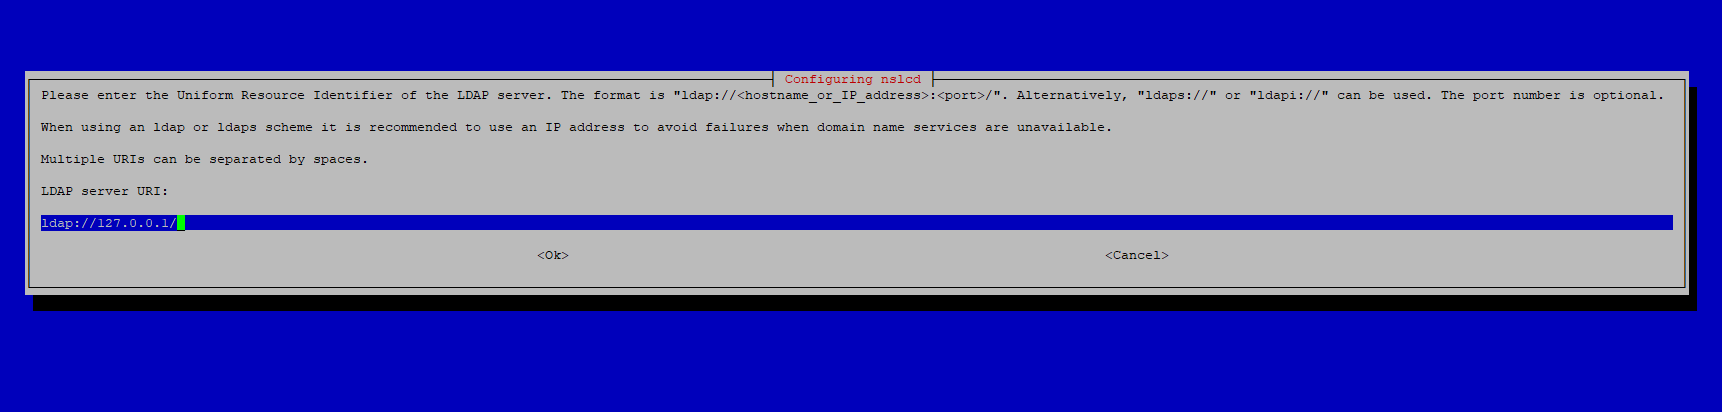

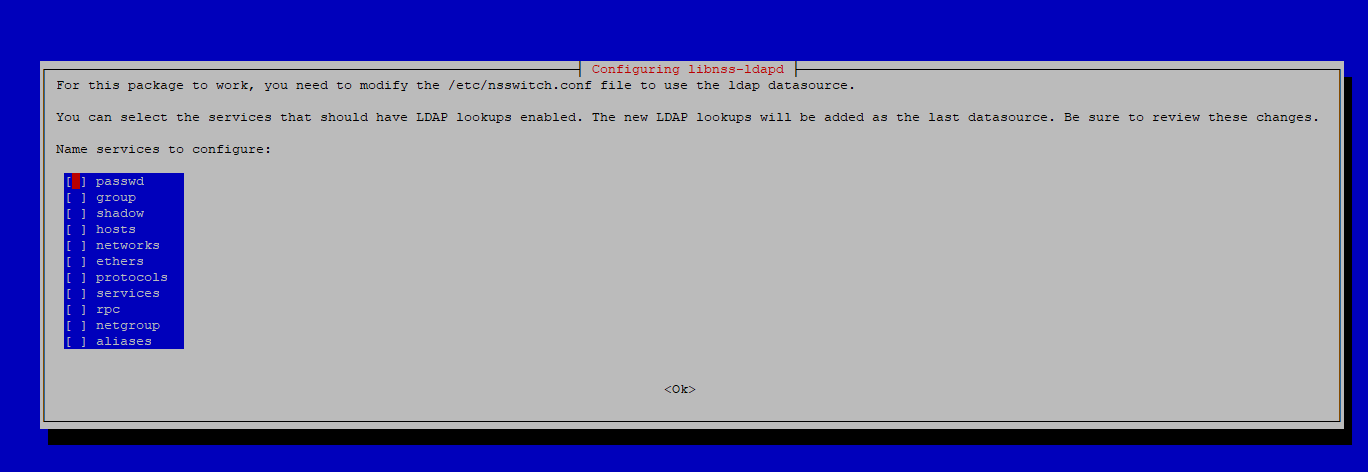

#### 4. Редактируем файл, чтобы FreeRADIUS использовал учётную запись с правами администратора
```
vim /etc/freeradius/3.0/radiusd.conf
```

Поиск: `:/user =`

```
user = freerad
group = freerad
````
Заменяем на: 
```
user = root
group = root
```

#### 5. Редактируем файл для комбинирования пользовательских паролей и кодов, генерируемых Google Authenticator
```
vim /etc/freeradius/3.0/sites-enabled/default
```
Должно получиться так:
```
# Pluggable Authentication Modules.
pam
```

#### 6. Проверить наличие модуля `pam`

```
cd /etc/freeradius/3.0/mods-enabled
```

Если модуля нет, то создать символическую ссылку:
```
ln -s /etc/freeradius/3.0/mods-available/pam /etc/freeradius/3.0/mods-enabled/pam
```

#### 7.  PAM configuration for FreeRADIUS. Редактируем файл:
```
vim /etc/pam.d/radiusd
```

> Закомментировать эти строки:
```
#@include common-auth
#@include common-account
#@include common-password
#@include common-session
```
> Добавить эти строки (`Shift`+`Insert`):
```
auth requisite pam_google_authenticator.so forward_pass debug
auth [success=2 default=ignore] pam_ldap.so minimum_uid=1000 use_first_pass debug
auth [success=1 default=ignore] pam_unix.so nullok_secure debug
auth requisite pam_deny.so
auth required pam_permit.so
```

#### 8. Создание пользовательских директорий на стороне RADIUS-сервера. Редактируем файл:
```
vim /etc/pam.d/common-session
```

> Добавляем в конец файла:
```
# make home directories
session required pam_mkhomedir.so skel=/etc/skel/ umask=0077
```

#### 9. Конфигурируем LDAPD

#### 9.1. `nsswitch.conf` (`vim /etc/nsswitch.conf`)
```
passwd: compat ldap
group: compat ldap
shadow: compat ldap
gshadow: files

hosts: files dns ldap
networks: files

protocols: db files
services: db files
ethers: db files
rpc: db files

netgroup: nis
```

#### 9.2. `nslcd.conf` (`vim /etc/nslcd.conf`)
```
# The user and group nslcd should run as.
uid nslcd
gid nslcd

# The location at which the LDAP server(s) should be reachable.
uri ldap://winddc.test.ad/

# The search base that will be used for all queries.
base dc=test,dc=ad
ssl no
# The LDAP protocol version to use.
ldap_version 3

# The DN to bind with for normal lookups.
binddn administrator@test.ad
bindpw P@ssw0rd

# SSL options
#ssl off
tls_reqcert never
tls_cacertfile /etc/ssl/certs/ca-certificates.crt
# The search scope.
scope sub
```

> Mapping for Active Directory

```
# replace the SIDs in the objectSid mappings with the value for your domain
pagesize 1000
referrals off
idle_timelimit 800
filter passwd (&(objectClass=user)(objectClass=person)(!(objectClass=computer)))
map passwd uid cn
map passwd uidNumber objectSid:S-1-5-21-3593493845-2842641097-1227278272
map passwd gidNumber objectSid:S-1-5-21-3593493845-2842641097-1227278272
map passwd homeDirectory "/home/$cn"
map passwd gecos displayName
map passwd loginShell "/bin/bash"
filter group (|(objectClass=group)(objectClass=person))
map group gidNumber objectSid:S-1-5-21-3593493845-2842641097-1227278272
```


_______
SID своей доменной учетной записи командой:
```
whoami /user
```

`objectSid`: S-1-5-21-3997609503-992433755-1954237486-500
_______

#### 9.3. `nscd.conf` (`vim /etc/nscd.conf`)

```
enable-cache no
```

#### 10.  Перезагружаем сервер
```
systemctl reboot
```

#### 11. Добавляем клиента RADIUS-сервера

Клиенты — рабочие станции и серверы, которые проходят аутентификацию через RADIUS-сервер.

Редактируем файл:
```
vim /etc/freeradius/3.0/clients.conf
```

```
Client clnt-name {
secret = testing123
shortname = clnt-name
ipaddr = 10.20.43.221
}
```
`ipaddr` - ip-адрес RADIUS-клиента,
`secret` - для проверки разрешения на аутентификацию.

#### 12. Получаем google-authenticator
Создание нового пользователя не требуется, т.к. аутентификация происходит через наш домен. Все необходимые подготовительные действия – создание пользовательской директории – будут выполнены в момент первого входа на RADIUS-сервер.
> Входим под пользователем домена:
```
su <user>
```
> Проверяем, что мы оказались в своей директории.

> Создаем идентификатор:
```
google-authenticator
```

#### 13. Проверка 
> Перезапустить freeradius:
```
sudo service freeradius restart
```
или
```
sudo /etc/init.d/freeradius restart
```

> Для проверки правильности конфигураций:
```
radtest <username> <unix_password><google_auth> localhost 18120 testing123
```